# Time Series Analysis & Forecasting 📈

**Project Objective:** To build a time series model to forecast the number of airline passengers for future months. This project provides a comprehensive, step-by-step guide to time series analysis, from data decomposition and stationarity testing to building and evaluating ARIMA and SARIMA models.

### Importing Libraries and Loading Data

In [8]:
!pip install statsmodels

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [10]:
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

fatal: destination path '21-Days-21-Projects-Dataset' already exists and is not an empty directory.


In [11]:
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/airline_passenger_timeseries.csv')
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### Exploratory Data Analysis & Decomposition

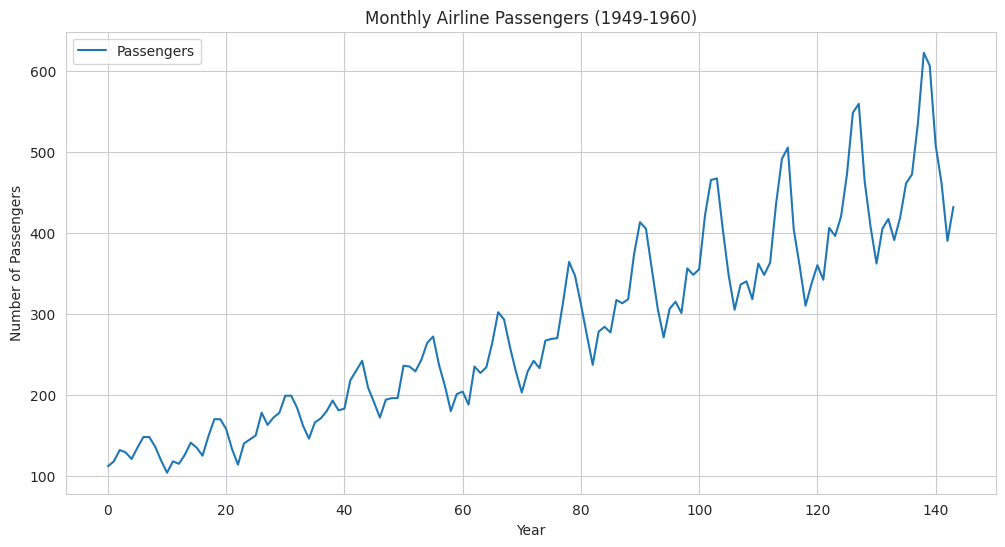

In [12]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

**Initial Observation:** The plot reveals three prominent trends:

1. **Upward Trend:** There is a steady increase in the number of passengers over time.
2. **Seasonality:** A distinct annual pattern is evident, with consistent peaks and valleys each year.
3. **Growing Variance:** The magnitude of seasonal fluctuations seems to be expanding as time progresses.


In [13]:
# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


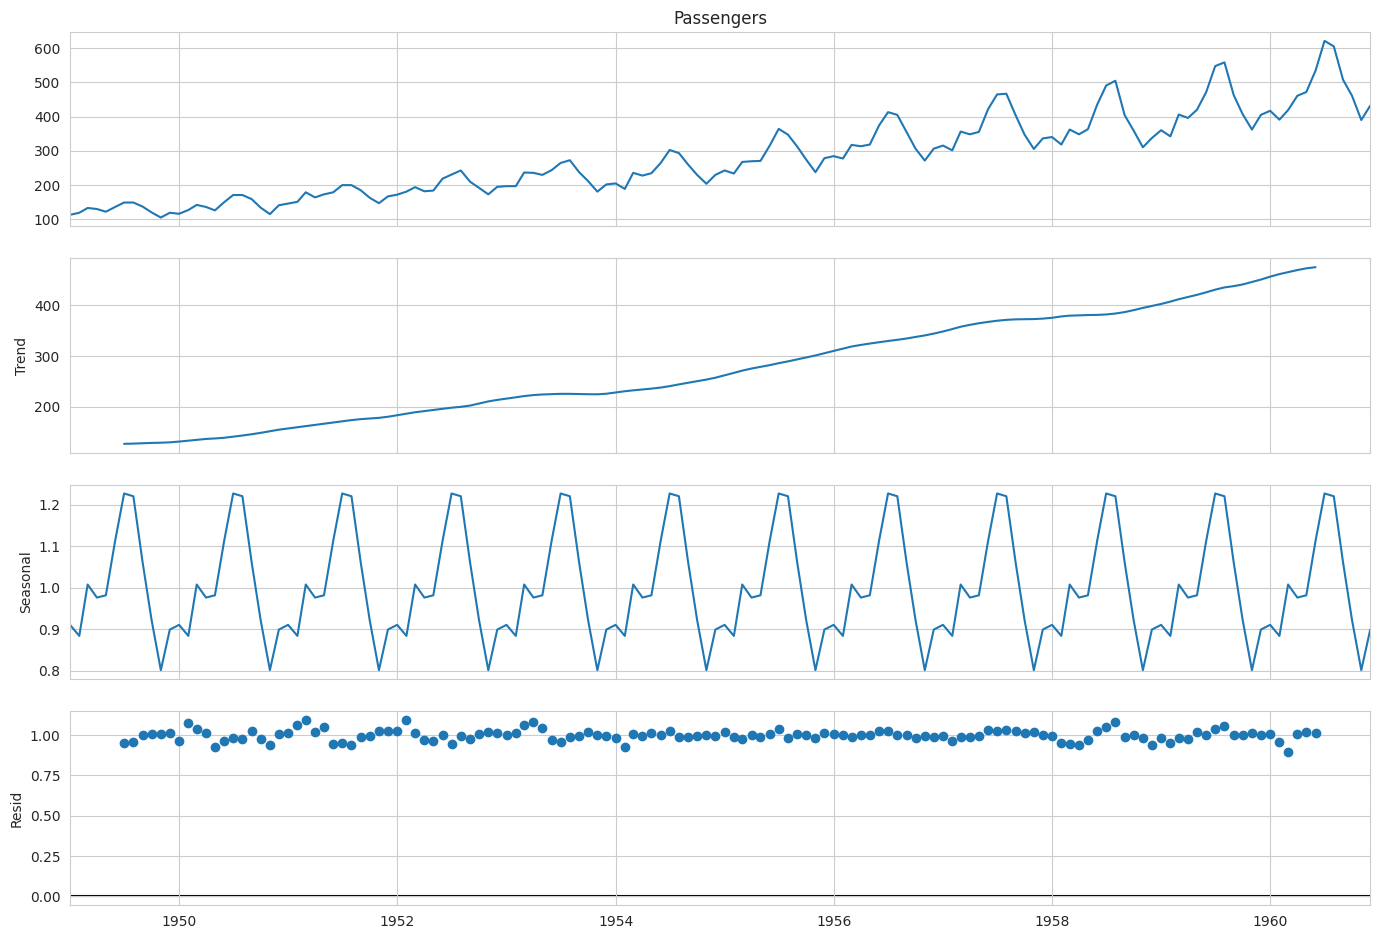

In [14]:
# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

### Stationarity Testing

In [15]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Making the Series Stationary


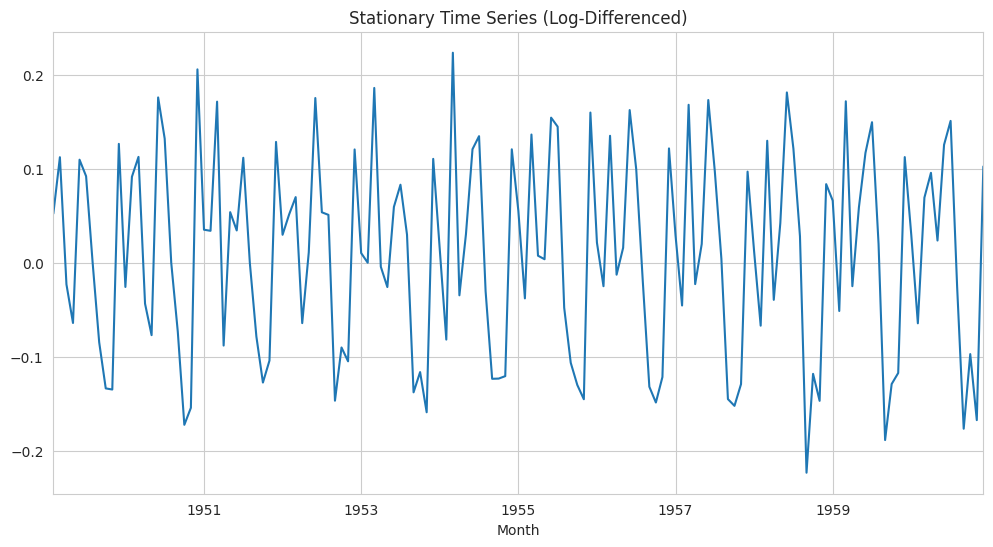

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [16]:
# 1. Apply log transformation to stabilize the variance
df_log = np.log(df['Passengers'])

# 2. Apply differencing to remove the trend
df_diff = df_log.diff().dropna()

# Plot the stationary series
df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

# Retest for stationarity
test_stationarity(df_diff)

The p-value is 0.07, which is not enough for completly rejecting the Null hypothesis.

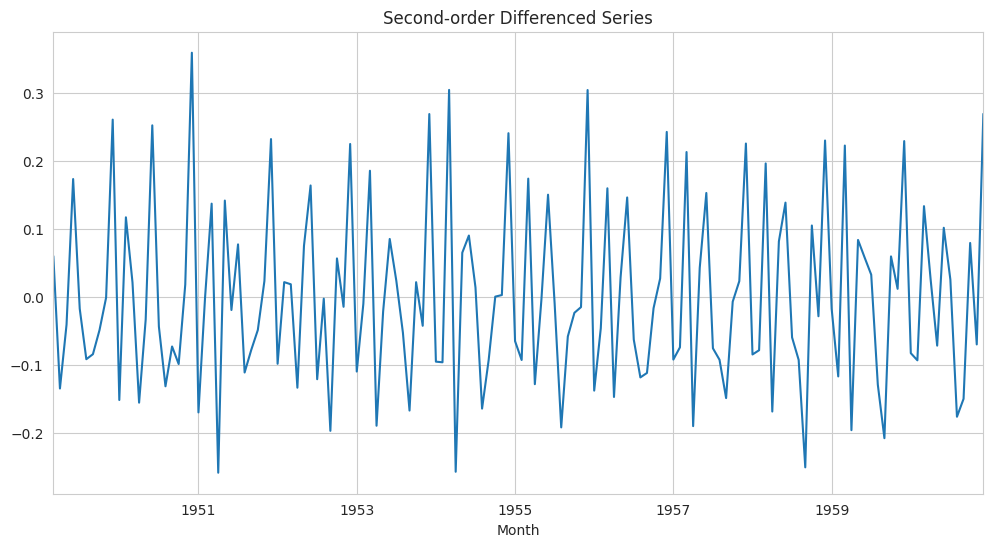

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


In [17]:
# Second-order differencing
df_diff2 = df_log.diff().diff().dropna()

# Plot the second-order differenced series
df_diff2.plot()
plt.title('Second-order Differenced Series')
plt.show()

# Retest stationarity
test_stationarity(df_diff2)


**Result:** The new `p-value ≈ 7.42e-13`, which is way below than 0.05, confirming stationary and ready for modeling!

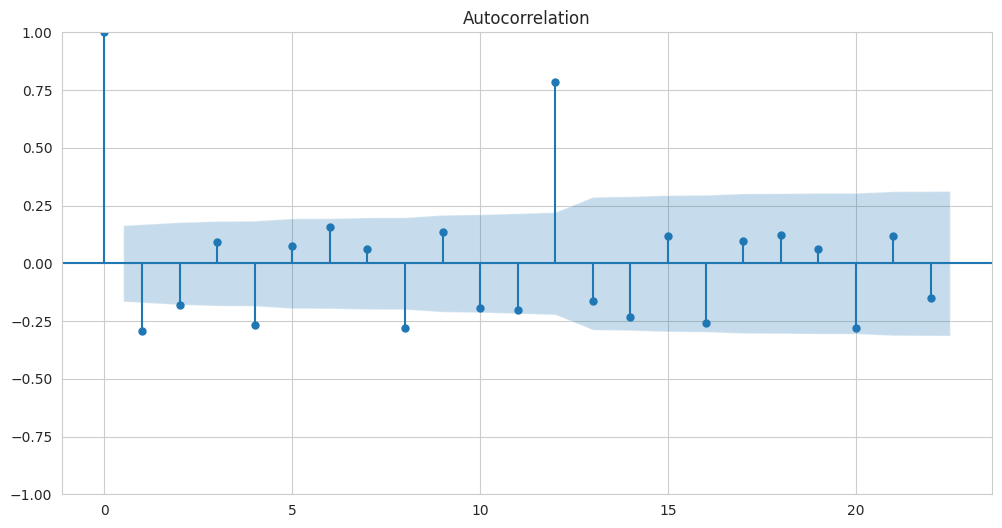

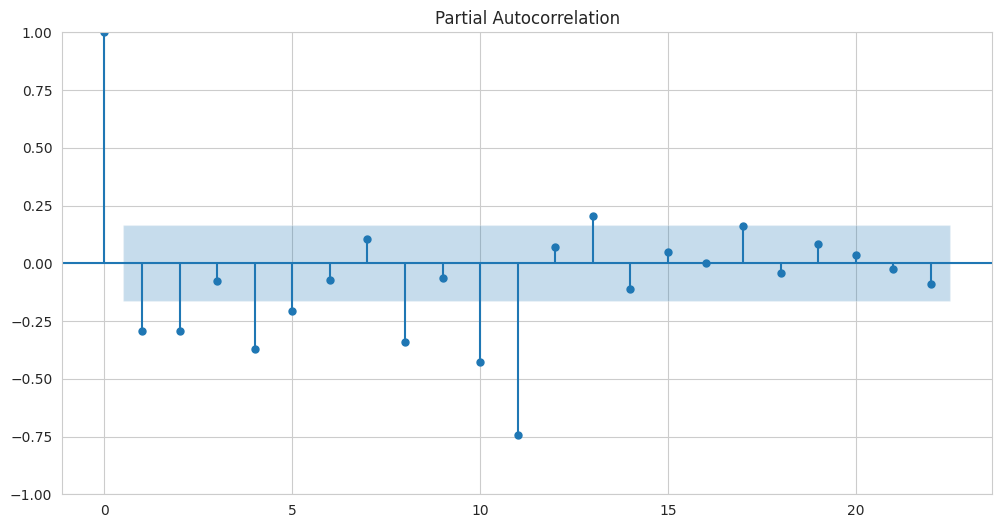

In [18]:
# ACF and PACF plots
plot_acf(df_diff2)
plt.show()

plot_pacf(df_diff2)
plt.show()


Since we did second-order differencing, d=2 for ARIMA

In [19]:
# Fit ARIMA (p,d,q)
model = ARIMA(df_log, order=(2,2,2))  # example: p=2, d=2, q=2
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 121.178
Date:                Tue, 21 Oct 2025   AIC                           -232.355
Time:                        06:57:12   BIC                           -217.576
Sample:                    01-01-1949   HQIC                          -226.350
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5783      0.171     -3.388      0.001      -0.913      -0.244
ar.L2          0.0370      0.118      0.313      0.754      -0.195       0.269
ma.L1         -0.1340      2.537     -0.053      0.9

### Forecasting

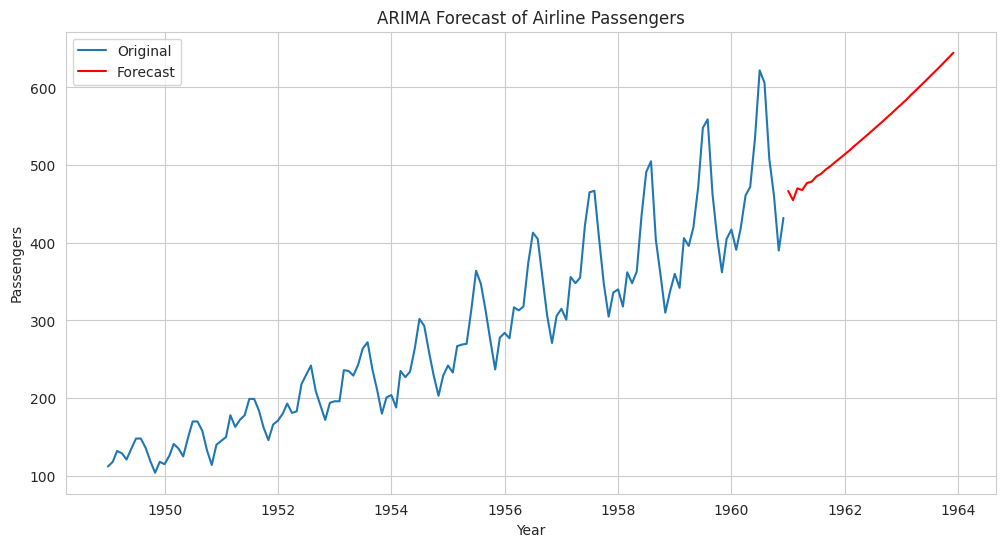

In [20]:
# Forecast next 36 months
forecast_steps = 36
forecast = model_fit.forecast(steps=forecast_steps)

# Convert back from log
forecast_values = np.exp(forecast)

# Plot original + forecast
plt.plot(df['Passengers'], label='Original')
plt.plot(forecast_values, color='red', label='Forecast')
plt.title('ARIMA Forecast of Airline Passengers')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.legend()
plt.show()
